# Results
In this notebook we analyze the results of the noisy quantum reservoirs for the three noise models.

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import pauli_basis
import umap
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm 
from qiskit.opflow import StateFn
from qiskit.opflow import Z,X,Y
from qiskit.quantum_info import Pauli
from qiskit.opflow import *
from qiskit.circuit.library import Diagonal
from qiskit.extensions import  UnitaryGate
from qiskit import QuantumCircuit,execute
from qiskit import BasicAer
from qiskit.compiler import transpile
from sklearn.model_selection import train_test_split
from qiskit.quantum_info import Statevector
from scipy.stats import unitary_group
from qiskit import IBMQ, Aer
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

from os import listdir
from os.path import isfile, join
from sklearn.linear_model import Ridge
import random 
import pandas as pd
import pickle

warnings.filterwarnings('ignore')

C:\Users\laiad\AppData\Local\Temp/ipykernel_8536/726459699.py:22: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


## 1. Paper setting

<div>
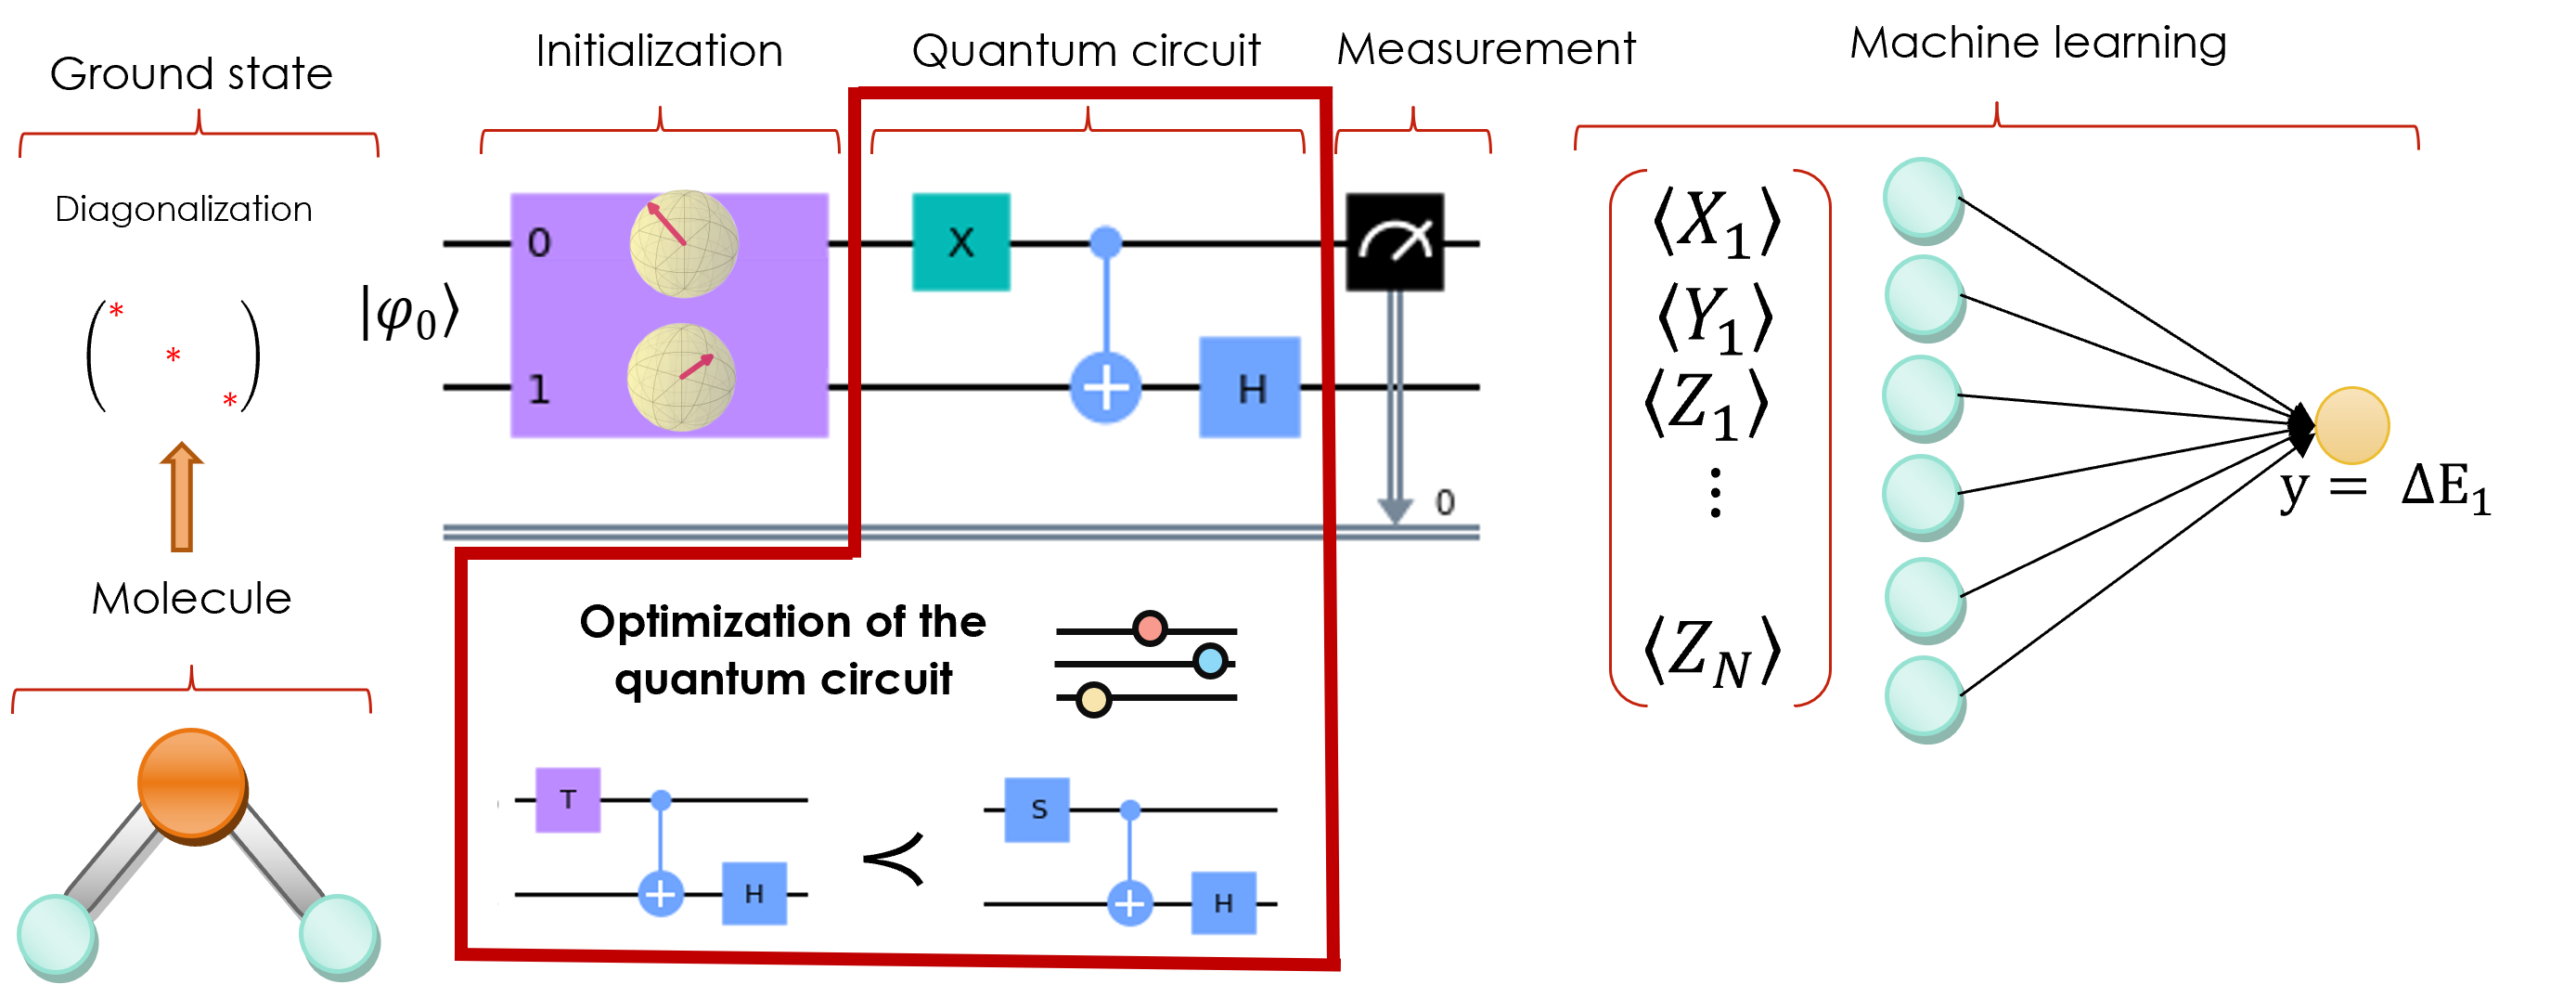
</div>



## Performance results

We now analyze the performance of the quantum reservoirs for the amplitude damping noise, the depolarizing noise and the phase damping noise. The task consists of predictinng the excited state energy of the LiH molecule.

In [2]:
with open('../training_data/spectrums_LiH.npy', 'rb') as f:
            spectrums = np.load(f)
with open('../training_data/bond_lengths_LiH.npy', 'rb') as f:
            bond_lengths = np.load(f)
with open('../training_data/ground_states_LiH.npy', 'rb') as f:
            ground_states = np.load(f)
        
num_states = ground_states.shape[0]
y = np.zeros((num_states, 2))
y[:,0] = spectrums[:,1] - spectrums[:,0]
y[:,1] = spectrums[:,2] - spectrums[:,0]


## 1. Amplitude damping

In [4]:
path = []
files = []
names = []
for noise in ['0','0001','0005','001', '003']:
    for gates in ['25','35','45','55','65','75','85','95','105','115','125','135','145',
                  '155','165','175','185','195','205','215', '300', '500', '700', '900' ]:
        if noise!='0':
            path_name = '../results/partial_noise/G3/amplitude_damping/'+noise+'/'+gates+'/'
        else:
            path_name = '../results/partial_noise/G3/amplitude_damping/'+noise+'/'+gates+'/'
        files_names = [f for f in listdir(path_name) if isfile(join(path_name, f))]
        names.append('AD_'+ noise +'_'+gates)
        path.append(path_name)
        files.append(files_names)

### Prediction errors

In [6]:
alpha = 1e-9
alpha2 = 1e-9
mses1 = []
mses2 = []
for i in tqdm(range(len(files))):
    file_list = files[i]
    mse_list1 = []  
    mse_list2 = [] 
    for file in file_list:
        #try:
            # Load results
            with open(path[i] + file, 'rb') as f:
                obs_res = np.load(f, allow_pickle=True) 
            try:
                non_zero_obs = [~np.isclose(obs_res[:,j],0).all() for j in range(obs_res.shape[1])]
            except:
                obs_res = obs_res.tolist()['observables_noise']
                non_zero_obs = [~np.isclose(obs_res[:,j],0).all() for j in range(obs_res.shape[1])]
            if sum(non_zero_obs)>0:
                obs_res = obs_res[:,non_zero_obs]
            obs_res = obs_res[:, ~np.isnan(obs_res).any(axis=0)]
            # Separate train and test uniformly
            size = obs_res.shape[0]
            idx1 = int(0.2*size)
            idx2 = int(0.5*size)
            train_idx=list(range(idx1)) + list(range(idx2, size))
            X_train, y_train, bond_lengths_train = obs_res[train_idx], y[train_idx], bond_lengths[train_idx]
            X_test, y_test, bond_lengths_test = obs_res[idx1:idx2], y[idx1:idx2], bond_lengths[idx1:idx2]
            #X_train, X_test, y_train, y_test, bond_lengths_train, bond_lengths_test = train_test_split( 
            #        obs_res, y, bond_lengths, test_size=0.33, random_state=42)
            # Scale target
            scaler = MinMaxScaler()
            y_train_scaled = scaler.fit_transform(y_train)
            y_test_scaled = scaler.transform(y_test)
            # Fit linear model
            alpha_sel = alpha if i>24 else alpha2
            lm1 = Ridge(alpha=alpha_sel)
            lm1.fit(X_train, y_train_scaled[:,0])
            lm2 = Ridge(alpha=alpha_sel)
            lm2.fit(X_train, y_train_scaled[:,1])
            # Predict
            y_hat1 = lm1.predict(X_test)
            y_hat2 = lm2.predict(X_test)
            y_hat = np.vstack([y_hat1, y_hat2]).T
            y_hat = scaler.inverse_transform(y_hat)
            
            
            idx_rm = (y_hat[:,0]>0.09) | (y_hat[:,0]<0.0)
            y_hat_n = y_hat[~idx_rm,0]
            y_test_n = y_test[~idx_rm,0]
            
            idx_rm2 = (y_hat[:,1]>0.15) | (y_hat[:,1]<0.05)
            y_hat_n2 = y_hat[~idx_rm,1]
            y_test_n2 = y_test[~idx_rm,1]
            # MSE
            mse1 = np.mean(np.square(y_hat_n - y_test_n))
            mse2 = np.mean(np.square(y_hat_n2 - y_test_n2))
            mse_list1.append(mse1)
            mse_list2.append(mse2)
        #except:
        #    print(path[i] + file)
    mses1.append(mse_list1)
    mses2.append(mse_list2)

mses1 = [np.mean(mse) for mse in mses1]
mses2 = [np.mean(mse) for mse in mses2]

results = pd.DataFrame([mses1, mses2], columns=names, index=['MSE1', 'MSE2']).T
#results.to_csv('mse_amplitude_damping.csv')

100%|██████████| 120/120 [02:06<00:00,  1.05s/it]


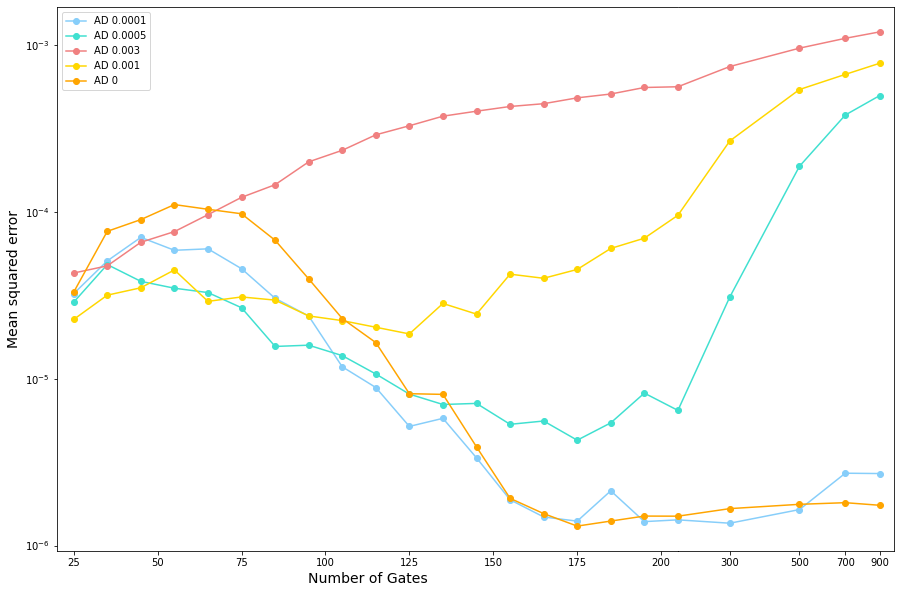

In [7]:
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

x = [25,35,45,55,65,75,85,95,105,115,125,135,145,155,165,175,185,195,205,300,500,700,900]
colors = ['lightskyblue', 'lightcoral', 'turquoise', 'black', 'gold', 'orange', 'lightgreen', 'mediumpurple']

#LIH '0','0001','0005','001', '003'
mses_AD_0001 = results['MSE1'][['AD_0001_'+ str(n) for n in x]]
mses_AD_0005 = results['MSE1'][['AD_0005_'+ str(n) for n in x]]
mses_AD_003 = results['MSE1'][['AD_003_'+ str(n) for n in x]]
mses_AD_001 = results['MSE1'][['AD_001_'+ str(n) for n in x]]
mses_AD_0 = results['MSE1'][['AD_0_'+ str(n) for n in x]]


fig, (ax1) = plt.subplots(1, 1,figsize = (15,10))

ax1.plot(x, mses_AD_0001, marker='o', color = colors[0], label ='AD 0.0001')
ax1.plot(x, mses_AD_0005, marker='o', color = colors[2], label ='AD 0.0005')
ax1.plot(x, mses_AD_003, marker='o', color = colors[1], label ='AD 0.003')
ax1.plot(x, mses_AD_001, marker='o', color = colors[4], label ='AD 0.001')
ax1.plot(x, mses_AD_0, marker='o', color = colors[5], label ='AD 0')


ax1.set_yscale('log')
ax1.set_xscale('linear')
ax1.set_xlim((20,205))

ax1.set_xlabel('Number of Gates',fontsize=14)
ax1.set_ylabel('Mean squared error',fontsize=14)
ax1.legend()

divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("right", size=3, pad=0, sharey=ax1)
ax2.set_xscale('log')
ax2.set_xlim((205,1000))
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_xticks([300,500,700,900], ['300','500','700', '900'], minor=False)
#plt.setp(ax2.get_xticklabels(), visible=True)
plt.minorticks_off()


ax2.plot(x, mses_AD_0001, marker='o', color = colors[0], label ='AD 0.0001')
ax2.plot(x, mses_AD_0005, marker='o', color = colors[2], label ='AD 0.0005')
ax2.plot(x, mses_AD_003, marker='o', color = colors[1], label ='AD 0.003')
ax2.plot(x, mses_AD_001, marker='o', color = colors[4], label ='AD 0.001')
ax2.plot(x, mses_AD_0, marker='o', color = colors[5], label ='AD 0')

plt.show()

### Fidelity

In [8]:
path = []
files = []
names = []
for noise in ['0001','0005','001', '003']:
    for gates in ['25','35','45','55','65','75','85','95','105','115','125','135','145',
                  '155','165','175','185','195','205','215', '300', '500', '700', '900' ]:
        path_name = '../results/partial_noise/G3/amplitude_damping/'+noise+'/'+gates+'/'
        files_names = [f for f in listdir(path_name) if isfile(join(path_name, f))]
        names.append('AD_'+ noise +'_'+gates)
        path.append(path_name)
        files.append(files_names)

In [9]:
fidelity = []
mse_obs = []
for i in tqdm(range(len(files))):
    file_list = files[i]
    fidelity_list = []  
    mse_obs_list = []
    for file in file_list:
        # Load results
        with open(path[i] + file, 'rb') as f:
            result = np.load(f, allow_pickle=True) 
        f = np.array(result.tolist()['fidelity_list'])
        mean_fidelity = np.mean(f)
        fidelity_list.append(mean_fidelity)

    fidelity.append(fidelity_list)
    
fidelity = [np.mean(f) for f in fidelity]
fidelity_results = pd.DataFrame([fidelity], columns=names, index=['fidelity']).T
#fidelity_results.to_csv('fidelity_amplitude_damping.csv')

100%|██████████| 96/96 [00:05<00:00, 16.98it/s]


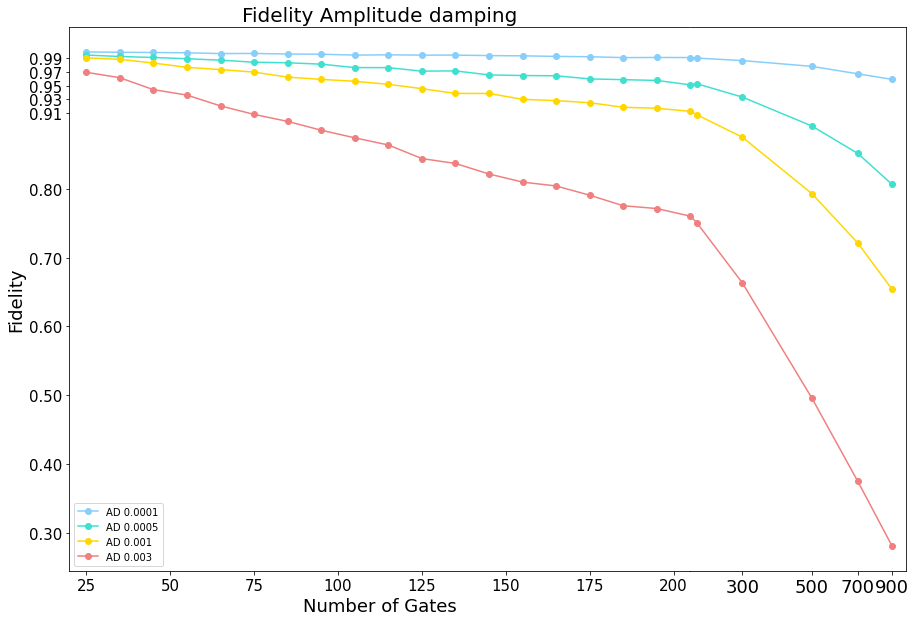

In [10]:
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid.inset_locator import inset_axes

x = [25,35,45,55,65,75,85,95,105,115,125,135,145,155,165,175,185,195,205,215,300,500, 700, 900 ]
colors = ['lightskyblue', 'lightcoral', 'turquoise', 'black', 'gold', 'orange', 'lightgreen', 'mediumpurple']

#LIH
fidelity_AD_0001 = fidelity_results['fidelity'][['AD_0001_'+ str(n) for n in x]]
fidelity_AD_0005 = fidelity_results['fidelity'][['AD_0005_'+ str(n) for n in x]]
fidelity_AD_001 = fidelity_results['fidelity'][['AD_001_'+ str(n) for n in x]]
fidelity_AD_003 = fidelity_results['fidelity'][['AD_003_'+ str(n) for n in x]]

fig, (ax1) = plt.subplots(1, 1,figsize = (15,10))

ax1.plot(x, fidelity_AD_0001, marker='o', color = colors[0], label ='AD 0.0001')
ax1.plot(x, fidelity_AD_0005, marker='o', color = colors[2], label ='AD 0.0005')
ax1.plot(x, fidelity_AD_001, marker='o', color = colors[4], label ='AD 0.001')
ax1.plot(x, fidelity_AD_003, marker='o', color = colors[1], label ='AD 0.003')
ax1.legend()
#ax1.set_yscale('log')
ax1.tick_params(axis='both',labelsize=15)
ax1.set_yticks([0.99,  0.97, 0.95, 0.93, 0.91, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3,0.2],labelsize=25)

ax1.set_xlabel('Number of Gates',fontsize=18)
ax1.set_ylabel('Fidelity',fontsize=18)
ax1.set_xlim((20,205))
ax1.legend()
plt.title('Fidelity Amplitude damping', fontsize=20)

divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("right", size=3, pad=0, sharey=ax1)
ax2.set_xscale('log')
ax2.set_xlim((205,1000))
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_xticks([300,500,700,900], ['300','500','700', '900'], minor=False, fontsize=18)
#plt.setp(ax2.get_xticklabels(), visible=True)
plt.minorticks_off()
ax2.plot(x, fidelity_AD_0001, marker='o', color = colors[0], label ='AD 0.0001')
ax2.plot(x, fidelity_AD_0005, marker='o', color = colors[2], label ='AD 0.0005')
ax2.plot(x, fidelity_AD_001, marker='o', color = colors[4], label ='AD 0.001')
ax2.plot(x, fidelity_AD_003, marker='o', color = colors[1], label ='AD 0.003')


plt.show()

## 2. Depolarizing noise

In [11]:
path = []
files = []
names = []
for noise in ['0','0001','0005','001', '003']:
    for gates in ['25','35','45','55','65','75','85','95','105','115','125','135','145',
                  '155','165','175','185','195','205','215', '300', '500', '700', '900' ]:
        if noise!='0':
            path_name = '../results/partial_noise/G3/depolarizing/'+noise+'/'+gates+'/'
        else:
            path_name = '../results/partial_noise/G3/amplitude_damping/'+noise+'/'+gates+'/'
        files_names = [f for f in listdir(path_name) if isfile(join(path_name, f))]
        names.append('DP_'+ noise +'_'+gates)
        path.append(path_name)
        files.append(files_names)

### Prediction errors

In [12]:
alpha = 1e-8
alpha2 = 1e-9
mses1 = []
mses2 = []
for i in tqdm(range(len(files))):
    file_list = files[i]
    mse_list1 = []  
    mse_list2 = [] 
    for file in file_list:
        #try:
            # Load results
            with open(path[i] + file, 'rb') as f:
                obs_res = np.load(f, allow_pickle=True) 
            try:
                non_zero_obs = [~np.isclose(obs_res[:,j],0).all() for j in range(obs_res.shape[1])]
            except:
                obs_res = obs_res.tolist()['observables_noise']
                non_zero_obs = [~np.isclose(obs_res[:,j],0).all() for j in range(obs_res.shape[1])]
            if sum(non_zero_obs)>0:
                obs_res = obs_res[:,non_zero_obs]
            obs_res = obs_res[:, ~np.isnan(obs_res).any(axis=0)]
            # Separate train and test uniformly
            size = obs_res.shape[0]
            idx1 = int(0.2*size)
            idx2 = int(0.5*size)
            train_idx=list(range(idx1)) + list(range(idx2, size))
            X_train, y_train, bond_lengths_train = obs_res[train_idx], y[train_idx], bond_lengths[train_idx]
            X_test, y_test, bond_lengths_test = obs_res[idx1:idx2], y[idx1:idx2], bond_lengths[idx1:idx2]
            #X_train, X_test, y_train, y_test, bond_lengths_train, bond_lengths_test = train_test_split( 
            #        obs_res, y, bond_lengths, test_size=0.33, random_state=42)
            # Scale target
            scaler = MinMaxScaler()
            y_train_scaled = scaler.fit_transform(y_train)
            y_test_scaled = scaler.transform(y_test)
            # Fit linear model
            alpha_sel = alpha if i>24 else alpha2
            lm1 = Ridge(alpha=alpha_sel)
            lm1.fit(X_train, y_train_scaled[:,0])
            lm2 = Ridge(alpha=alpha_sel)
            lm2.fit(X_train, y_train_scaled[:,1])
            # Predict
            y_hat1 = lm1.predict(X_test)
            y_hat2 = lm2.predict(X_test)
            y_hat = np.vstack([y_hat1, y_hat2]).T
            y_hat = scaler.inverse_transform(y_hat)
            
            
            idx_rm = (y_hat[:,0]>0.09) | (y_hat[:,0]<0.0)
            y_hat_n = y_hat[~idx_rm,0]
            y_test_n = y_test[~idx_rm,0]
            
            idx_rm2 = (y_hat[:,1]>0.15) | (y_hat[:,1]<0.05)
            y_hat_n2 = y_hat[~idx_rm,1]
            y_test_n2 = y_test[~idx_rm,1]
            # MSE
            mse1 = np.mean(np.square(y_hat_n - y_test_n))
            mse2 = np.mean(np.square(y_hat_n2 - y_test_n2))
            mse_list1.append(mse1)
            mse_list2.append(mse2)
        #except:
        #    print(path[i] + file)
    mses1.append(mse_list1)
    mses2.append(mse_list2)

mses1 = [np.mean(mse) for mse in mses1]
mses2 = [np.mean(mse) for mse in mses2]

results = pd.DataFrame([mses1, mses2], columns=names, index=['MSE1', 'MSE2']).T
#results.to_csv('mse_depolarizing.csv')

100%|██████████| 120/120 [02:01<00:00,  1.01s/it]


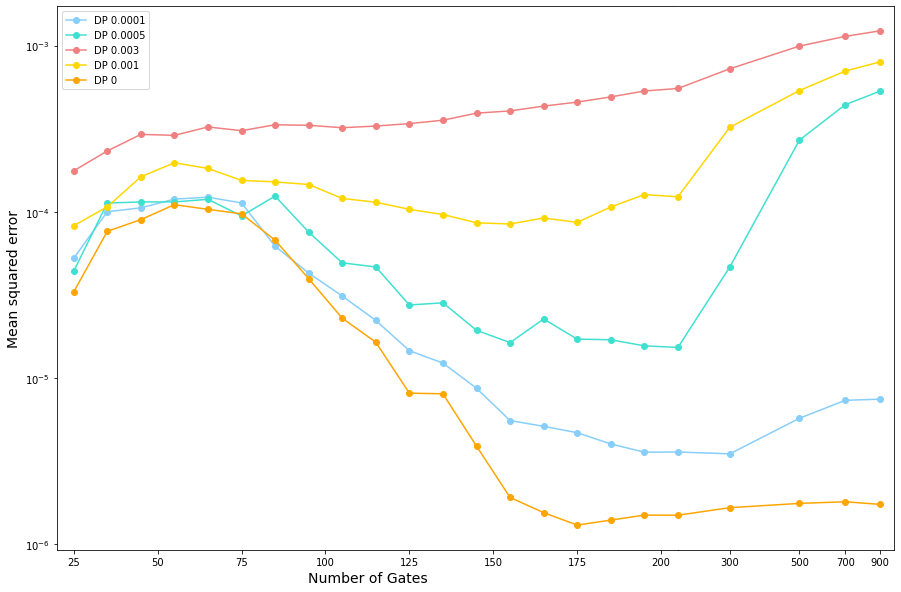

In [17]:
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

x = [25,35,45,55,65,75,85,95,105,115,125,135,145,155,165,175,185,195,205,300,500,700,900]
colors = ['lightskyblue', 'lightcoral', 'turquoise', 'black', 'gold', 'orange', 'lightgreen', 'mediumpurple']

#LIH 
mses_DP_0001 = results['MSE1'][['DP_0001_'+ str(n) for n in x]]
mses_DP_0005 = results['MSE1'][['DP_0005_'+ str(n) for n in x]]
mses_DP_003 = results['MSE1'][['DP_003_'+ str(n) for n in x]]
mses_DP_001 = results['MSE1'][['DP_001_'+ str(n) for n in x]]
mses_DP_0 = results['MSE1'][['DP_0_'+ str(n) for n in x]]


fig, (ax1) = plt.subplots(1, 1,figsize = (15,10))

ax1.plot(x, mses_DP_0001, marker='o', color = colors[0], label ='DP 0.0001')
ax1.plot(x, mses_DP_0005, marker='o', color = colors[2], label ='DP 0.0005')
ax1.plot(x, mses_DP_003, marker='o', color = colors[1], label ='DP 0.003')
ax1.plot(x, mses_DP_001, marker='o', color = colors[4], label ='DP 0.001')
ax1.plot(x, mses_DP_0, marker='o', color = colors[5], label ='DP 0')


ax1.set_yscale('log')
ax1.set_xscale('linear')
ax1.set_xlim((20,205))

ax1.set_xlabel('Number of Gates',fontsize=14)
ax1.set_ylabel('Mean squared error',fontsize=14)
ax1.legend()

divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("right", size=3, pad=0, sharey=ax1)
ax2.set_xscale('log')
ax2.set_xlim((205,1000))
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_xticks([300,500,700,900], ['300','500','700', '900'], minor=False)
plt.minorticks_off()


ax2.plot(x, mses_DP_0001, marker='o', color = colors[0], label ='DP 0.0001')
ax2.plot(x, mses_DP_0005, marker='o', color = colors[2], label ='DP 0.0005')
ax2.plot(x, mses_DP_003, marker='o', color = colors[1], label ='DP 0.003')
ax2.plot(x, mses_DP_001, marker='o', color = colors[4], label ='DP 0.001')
ax2.plot(x, mses_DP_0, marker='o', color = colors[5], label ='DP 0')

plt.show()

### Fidelity

In [14]:
path = []
files = []
names = []
for noise in ['0001','0005','001', '003']:
    for gates in ['25','35','45','55','65','75','85','95','105','115','125','135','145',
                  '155','165','175','185','195','205','215', '300', '500', '700', '900' ]:
        path_name = '../results/partial_noise/G3/depolarizing/'+noise+'/'+gates+'/'
        files_names = [f for f in listdir(path_name) if isfile(join(path_name, f))]
        names.append('DP_'+ noise +'_'+gates)
        path.append(path_name)
        files.append(files_names)

In [15]:
fidelity = []
mse_obs = []
for i in tqdm(range(len(files))):
    file_list = files[i]
    fidelity_list = []  
    mse_obs_list = []
    for file in file_list:
        # Load results
        with open(path[i] + file, 'rb') as f:
            result = np.load(f, allow_pickle=True) 
        f = np.array(result.tolist()['fidelity_list'])
        mean_fidelity = np.mean(f)
        fidelity_list.append(mean_fidelity)

    fidelity.append(fidelity_list)
    
fidelity = [np.mean(f) for f in fidelity]
fidelity_results = pd.DataFrame([fidelity], columns=names, index=['fidelity']).T
#fidelity_results.to_csv('fidelity_depolarizing.csv')

100%|██████████| 96/96 [00:05<00:00, 17.74it/s]


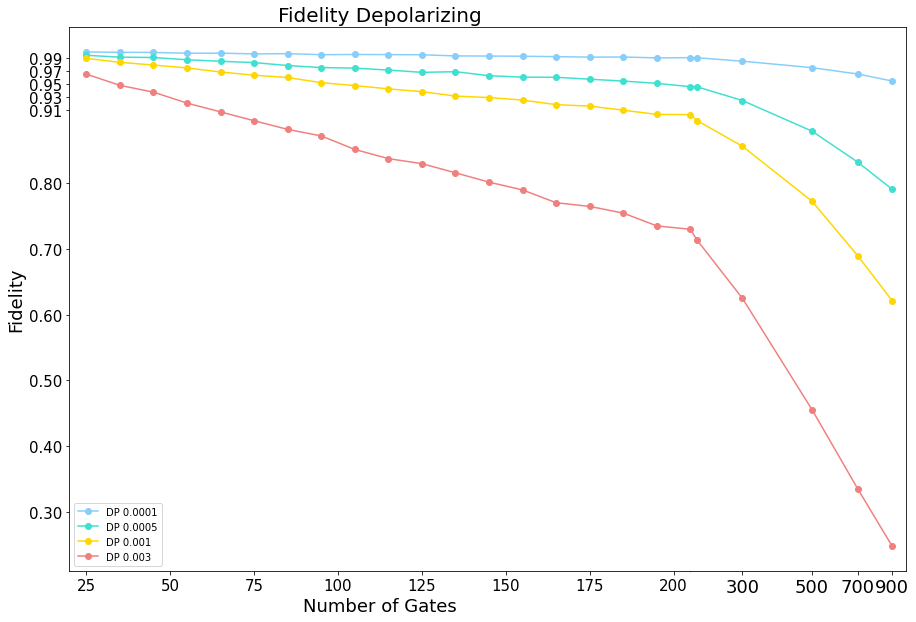

In [16]:
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid.inset_locator import inset_axes

x = [25,35,45,55,65,75,85,95,105,115,125,135,145,155,165,175,185,195,205,215,300,500, 700, 900 ]
colors = ['lightskyblue', 'lightcoral', 'turquoise', 'black', 'gold', 'orange', 'lightgreen', 'mediumpurple']

#LIH
fidelity_DP_0001 = fidelity_results['fidelity'][['DP_0001_'+ str(n) for n in x]]
fidelity_DP_0005 = fidelity_results['fidelity'][['DP_0005_'+ str(n) for n in x]]
fidelity_DP_001 = fidelity_results['fidelity'][['DP_001_'+ str(n) for n in x]]
fidelity_DP_003 = fidelity_results['fidelity'][['DP_003_'+ str(n) for n in x]]

fig, (ax1) = plt.subplots(1, 1,figsize = (15,10))

ax1.plot(x, fidelity_DP_0001, marker='o', color = colors[0], label ='DP 0.0001')
ax1.plot(x, fidelity_DP_0005, marker='o', color = colors[2], label ='DP 0.0005')
ax1.plot(x, fidelity_DP_001, marker='o', color = colors[4], label ='DP 0.001')
ax1.plot(x, fidelity_DP_003, marker='o', color = colors[1], label ='DP 0.003')
ax1.legend()
#ax1.set_yscale('log')
ax1.tick_params(axis='both',labelsize=15)
ax1.set_yticks([0.99,  0.97, 0.95, 0.93, 0.91, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3,0.2],labelsize=25)

ax1.set_xlabel('Number of Gates',fontsize=18)
ax1.set_ylabel('Fidelity',fontsize=18)
ax1.set_xlim((20,205))
ax1.legend()
plt.title('Fidelity Depolarizing', fontsize=20)

divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("right", size=3, pad=0, sharey=ax1)
ax2.set_xscale('log')
ax2.set_xlim((205,1000))
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_xticks([300,500,700,900], ['300','500','700', '900'], minor=False, fontsize=18)

plt.minorticks_off()
ax2.plot(x, fidelity_DP_0001, marker='o', color = colors[0], label ='DP 0.0001')
ax2.plot(x, fidelity_DP_0005, marker='o', color = colors[2], label ='DP 0.0005')
ax2.plot(x, fidelity_DP_001, marker='o', color = colors[4], label ='DP 0.001')
ax2.plot(x, fidelity_DP_003, marker='o', color = colors[1], label ='DP 0.003')

plt.show()

## 3. Phase damping 

In [21]:
path = []
files = []
names = []
for noise in ['0','0001','0005','001', '003']:
    for gates in ['25','35','45','55','65','75','85','95','105','115','125','135','145',
                  '155','165','175','185','195','205','215', '300', '500', '700', '900' ]:
        if noise!='0':
            path_name = '../results/partial_noise/G3/phase_damping/'+noise+'/'+gates+'/'
        else:
            path_name = '../results/partial_noise/G3/amplitude_damping/'+noise+'/'+gates+'/'
        files_names = [f for f in listdir(path_name) if isfile(join(path_name, f))]
        names.append('PD_'+ noise +'_'+gates)
        path.append(path_name)
        files.append(files_names)

### Prediction errors

In [22]:
alpha = 1e-9
alpha2 = 1e-9
mses1 = []
mses2 = []
for i in tqdm(range(len(files))):
    file_list = files[i]
    mse_list1 = []  
    mse_list2 = [] 
    for file in file_list:
        #try:
            # Load results
            with open(path[i] + file, 'rb') as f:
                obs_res = np.load(f, allow_pickle=True) 
            try:
                non_zero_obs = [~np.isclose(obs_res[:,j],0).all() for j in range(obs_res.shape[1])]
            except:
                obs_res = obs_res.tolist()['observables_noise']
                non_zero_obs = [~np.isclose(obs_res[:,j],0).all() for j in range(obs_res.shape[1])]
            if sum(non_zero_obs)>0:
                obs_res = obs_res[:,non_zero_obs]
            obs_res = obs_res[:, ~np.isnan(obs_res).any(axis=0)]
            # Separate train and test uniformly
            size = obs_res.shape[0]
            idx1 = int(0.2*size)
            idx2 = int(0.5*size)
            train_idx=list(range(idx1)) + list(range(idx2, size))
            X_train, y_train, bond_lengths_train = obs_res[train_idx], y[train_idx], bond_lengths[train_idx]
            X_test, y_test, bond_lengths_test = obs_res[idx1:idx2], y[idx1:idx2], bond_lengths[idx1:idx2]
            #X_train, X_test, y_train, y_test, bond_lengths_train, bond_lengths_test = train_test_split( 
            #        obs_res, y, bond_lengths, test_size=0.33, random_state=42)
            # Scale target
            scaler = MinMaxScaler()
            y_train_scaled = scaler.fit_transform(y_train)
            y_test_scaled = scaler.transform(y_test)
            # Fit linear model
            alpha_sel = alpha if i>24 else alpha2
            lm1 = Ridge(alpha=alpha_sel)
            lm1.fit(X_train, y_train_scaled[:,0])
            lm2 = Ridge(alpha=alpha_sel)
            lm2.fit(X_train, y_train_scaled[:,1])
            # Predict
            y_hat1 = lm1.predict(X_test)
            y_hat2 = lm2.predict(X_test)
            y_hat = np.vstack([y_hat1, y_hat2]).T
            y_hat = scaler.inverse_transform(y_hat)
            
            
            idx_rm = (y_hat[:,0]>0.09) | (y_hat[:,0]<0.0)
            y_hat_n = y_hat[~idx_rm,0]
            y_test_n = y_test[~idx_rm,0]
            
            idx_rm2 = (y_hat[:,1]>0.15) | (y_hat[:,1]<0.05)
            y_hat_n2 = y_hat[~idx_rm,1]
            y_test_n2 = y_test[~idx_rm,1]
            # MSE
            mse1 = np.mean(np.square(y_hat_n - y_test_n))
            mse2 = np.mean(np.square(y_hat_n2 - y_test_n2))
            mse_list1.append(mse1)
            mse_list2.append(mse2)
        #except:
        #    print(path[i] + file)
    mses1.append(mse_list1)
    mses2.append(mse_list2)

mses1 = [np.mean(mse) for mse in mses1]
mses2 = [np.mean(mse) for mse in mses2]

results = pd.DataFrame([mses1, mses2], columns=names, index=['MSE1', 'MSE2']).T
#results.to_csv('mse_phase_damping.csv')

100%|██████████| 120/120 [01:58<00:00,  1.02it/s]


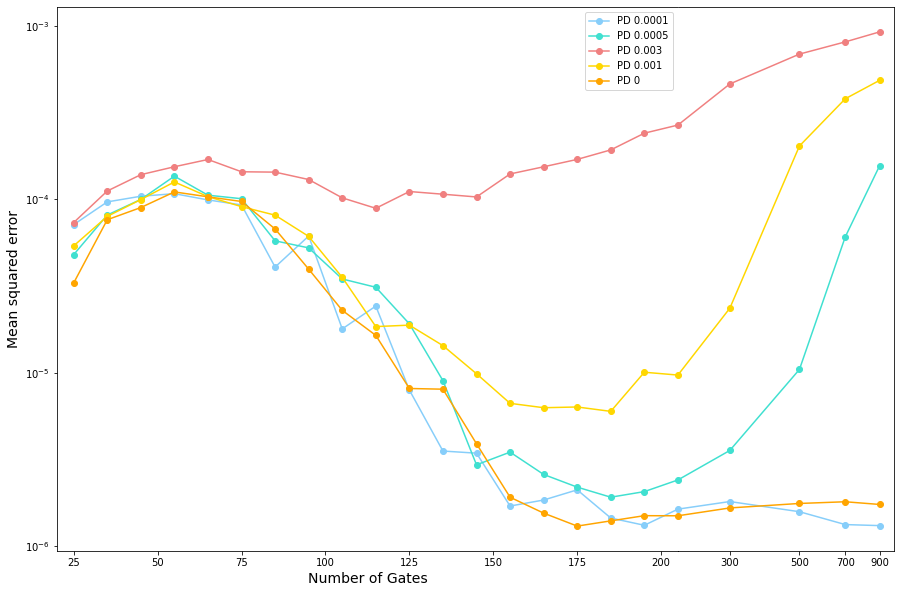

In [23]:
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

x = [25,35,45,55,65,75,85,95,105,115,125,135,145,155,165,175,185,195,205,300,500,700,900]
colors = ['lightskyblue', 'lightcoral', 'turquoise', 'black', 'gold', 'orange', 'lightgreen', 'mediumpurple']

#LIH '0','0001','0005','001', '003'
mses_PD_0001 = results['MSE1'][['PD_0001_'+ str(n) for n in x]]
mses_PD_0005 = results['MSE1'][['PD_0005_'+ str(n) for n in x]]
mses_PD_003 = results['MSE1'][['PD_003_'+ str(n) for n in x]]
mses_PD_001 = results['MSE1'][['PD_001_'+ str(n) for n in x]]
mses_PD_0 = results['MSE1'][['PD_0_'+ str(n) for n in x]]

fig, (ax1) = plt.subplots(1, 1,figsize = (15,10))

ax1.plot(x, mses_PD_0001, marker='o', color = colors[0], label ='PD 0.0001')
ax1.plot(x, mses_PD_0005, marker='o', color = colors[2], label ='PD 0.0005')
ax1.plot(x, mses_PD_003, marker='o', color = colors[1], label ='PD 0.003')
ax1.plot(x, mses_PD_001, marker='o', color = colors[4], label ='PD 0.001')
ax1.plot(x, mses_PD_0, marker='o', color = colors[5], label ='PD 0')


ax1.set_yscale('log')
ax1.set_xscale('linear')
ax1.set_xlim((20,205))

ax1.set_xlabel('Number of Gates',fontsize=14)
ax1.set_ylabel('Mean squared error',fontsize=14)
ax1.legend()

divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("right", size=3, pad=0, sharey=ax1)
ax2.set_xscale('log')
ax2.set_xlim((205,1000))
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_xticks([300,500,700,900], ['300','500','700', '900'], minor=False)
plt.minorticks_off()

ax2.plot(x, mses_PD_0001, marker='o', color = colors[0], label ='PD 0.0001')
ax2.plot(x, mses_PD_0005, marker='o', color = colors[2], label ='PD 0.0005')
ax2.plot(x, mses_PD_003, marker='o', color = colors[1], label ='PD 0.003')
ax2.plot(x, mses_PD_001, marker='o', color = colors[4], label ='PD 0.001')
ax2.plot(x, mses_PD_0, marker='o', color = colors[5], label ='PD 0')

plt.show()

### Fidelity

In [24]:
path = []
files = []
names = []
for noise in ['0001','0005','001', '003']:
    for gates in ['25','35','45','55','65','75','85','95','105','115','125','135','145',
                  '155','165','175','185','195','205','215', '300', '500', '700', '900' ]:
        path_name = '../results/partial_noise/G3/phase_damping/'+noise+'/'+gates+'/'
        files_names = [f for f in listdir(path_name) if isfile(join(path_name, f))]
        names.append('PD_'+ noise +'_'+gates)
        path.append(path_name)
        files.append(files_names)

In [25]:
fidelity = []
mse_obs = []
for i in tqdm(range(len(files))):
    file_list = files[i]
    fidelity_list = []  
    mse_obs_list = []
    for file in file_list:
        # Load results
        with open(path[i] + file, 'rb') as f:
            result = np.load(f, allow_pickle=True) 
        f = np.array(result.tolist()['fidelity_list'])
        mean_fidelity = np.mean(f)
        fidelity_list.append(mean_fidelity)

    fidelity.append(fidelity_list)
    
fidelity = [np.mean(f) for f in fidelity]
fidelity_results = pd.DataFrame([fidelity], columns=names, index=['fidelity']).T
#fidelity_results.to_csv('fidelity_phase_damping.csv')

100%|██████████| 96/96 [00:04<00:00, 21.49it/s]


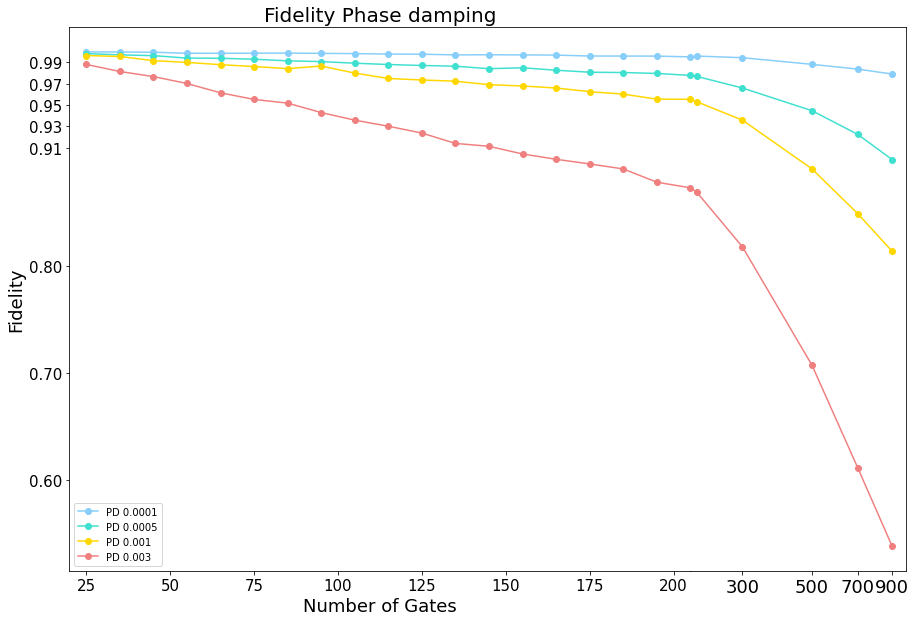

In [26]:
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid.inset_locator import inset_axes

x = [25,35,45,55,65,75,85,95,105,115,125,135,145,155,165,175,185,195,205,215,300,500, 700, 900 ]
colors = ['lightskyblue', 'lightcoral', 'turquoise', 'black', 'gold', 'orange', 'lightgreen', 'mediumpurple']

#LIH
fidelity_PD_0001 = fidelity_results['fidelity'][['PD_0001_'+ str(n) for n in x]]
fidelity_PD_0005 = fidelity_results['fidelity'][['PD_0005_'+ str(n) for n in x]]
fidelity_PD_001 = fidelity_results['fidelity'][['PD_001_'+ str(n) for n in x]]
fidelity_PD_003 = fidelity_results['fidelity'][['PD_003_'+ str(n) for n in x]]

fig, (ax1) = plt.subplots(1, 1,figsize = (15,10))

ax1.plot(x, fidelity_PD_0001, marker='o', color = colors[0], label ='PD 0.0001')
ax1.plot(x, fidelity_PD_0005, marker='o', color = colors[2], label ='PD 0.0005')
ax1.plot(x, fidelity_PD_001, marker='o', color = colors[4], label ='PD 0.001')
ax1.plot(x, fidelity_PD_003, marker='o', color = colors[1], label ='PD 0.003')
ax1.legend()
#ax1.set_yscale('log')
ax1.tick_params(axis='both',labelsize=15)
ax1.set_yticks([0.99,  0.97, 0.95, 0.93, 0.91, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3,0.2],labelsize=25)

ax1.set_xlabel('Number of Gates',fontsize=18)
ax1.set_ylabel('Fidelity',fontsize=18)
ax1.set_xlim((20,205))
ax1.legend()
plt.title('Fidelity Phase damping', fontsize=20)

divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("right", size=3, pad=0, sharey=ax1)
ax2.set_xscale('log')
ax2.set_xlim((205,1000))
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_xticks([300,500,700,900], ['300','500','700', '900'], minor=False, fontsize=18)
#plt.setp(ax2.get_xticklabels(), visible=True)
plt.minorticks_off()
ax2.plot(x, fidelity_PD_0001, marker='o', color = colors[0], label ='PD 0.0001')
ax2.plot(x, fidelity_PD_0005, marker='o', color = colors[2], label ='PD 0.0005')
ax2.plot(x, fidelity_PD_001, marker='o', color = colors[4], label ='PD 0.001')
ax2.plot(x, fidelity_PD_003, marker='o', color = colors[1], label ='PD 0.003')


plt.show()

## 4. Distribution in the Pauli space

We study the distribution of the noisy quantum states $\rho$ in the Pauli space for each of the three noise models. We compare it with randomly filling the space. For simplicity and better visualization, we use a toy model of just 2 qubits.

In [75]:
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
class QuantumCircQiskit:
    def __init__(self, gates_name, num_gates=50,nqbits=8,observables_type = 'fidelity',
                 err_type='depolarizing', err_p1=0.001, err_p2=0.01, err_idle=0.00001):
        
        self.num_gates = num_gates
        self.gates_name = gates_name
        self.observables_type = observables_type
        self.gates_set = []
        self.qubits_set = []
        self.nqbits=nqbits
        self.coupling_map=None
        self.err_type = err_type
        if err_type is not None:
            noise_model, basis_gates = self.get_noise_model(err_type=err_type, p1=err_p1, p2=err_p2, p_idle=err_idle)
        else:
            noise_model, basis_gates = None, None
            
        self.noise_model = noise_model
        self.basis_gates = basis_gates
        if self.gates_name=='G1':
            gates = ['CNOT', 'H', 'X']
        if self.gates_name=='G2':
            gates = ['CNOT', 'H', 'S']
        if self.gates_name=='G3':
            gates = ['CNOT', 'H', 'T']  
        
        qubit_idx = list(range(self.nqbits))
        # Store gates
        if self.gates_name in ['G1', 'G2', 'G3']:
            for i in range(self.num_gates):
                # Select random gate
                gate = random.sample(gates,1)[0] 
                self.gates_set.append(gate)
                if gate=='CNOT':
                    # Select qubit 1 and 2 (different qubits)
                    qbit1 = random.sample(qubit_idx,1)[0]
                    qubit_idx2 = qubit_idx.copy()
                    qubit_idx2.remove(qbit1)
                    qbit2 = random.sample(qubit_idx2,1)[0]
                    self.qubits_set.append([qbit1, qbit2])
                else:
                    # Select qubit
                    qbit = random.sample(qubit_idx,1)[0]
                    self.qubits_set.append([qbit])

                
    def initialization(self, initial_state):
        # 1. INITIALIZATION
        # Define initial state
        initial_state = initial_state.round(6)
        initial_state/=np.sqrt(np.sum(initial_state**2))

        # Define qiskit circuit to initialize quantum state
        self.nqbits = int(np.log2(initial_state.shape[0]))
        qc = QuantumCircuit(self.nqbits)
        qc.initialize(initial_state, list(range(self.nqbits)))
        return qc

    def apply_G_gates(self, qc):
        # Apply random gates to random qubits
        for i in range(self.num_gates):
            # Select random gate
            # Select random gate
            gate = self.gates_set[i]
            if gate=='CNOT': # For 2-qubit gates
                # Select qubit 1 and 2 (different qubits)
                qbit1, qbit2 = self.qubits_set[i]
                # Apply gate to qubits
                qc.cx(qbit1, qbit2) 
                # Appply identity operator to all idle qubits if we use an ide noise model
                if self.err_type=='depolarizing_idle' or self.err_type=='amplitude_damping_idle' or self.err_type=='phase_damping_idle':
                    qubit_idx = list(range(self.nqbits))
                    qubit_idx.remove(qbit1)
                    qubit_idx.remove(qbit2)
                    # Apply identity gates to other gates
                    for qbit in qubit_idx:
                        qc.id(qbit)
            else: # For 1-qubit gates
                # Select qubit
                qbit = self.qubits_set[i][0]
                if gate=='X':# Apply gate
                    qc.x(qbit) 
                if gate=='S':
                    qc.s(qbit) 
                if gate=='H':
                    qc.h(qbit) 
                if gate=='T':
                    qc.t(qbit) 
                # Appply identity operator to all idle qubits if we use an ide noise model
                if self.err_type=='depolarizing_idle' or self.err_type=='amplitude_damping_idle' or self.err_type=='phase_damping_idle':
                    qubit_idx = list(range(self.nqbits))
                    qubit_idx.remove(qbit)
                    # Apply identity gates to other gates
                    for qbit in qubit_idx:
                        qc.id(qbit)
                
    def gate_unitary(self, i):
        qc = QuantumCircuit(self.nqbits)
        # Apply random gates to random qubits
        gate = self.gates_set[i]
        if gate=='CNOT': # For 2-qubit gates
            # Select qubit 1 and 2 (different qubits)
            qbit1, qbit2 = self.qubits_set[i]
            # Apply gate to qubits
            qc.cx(qbit1, qbit2) 
            # Appply identity operator to all idle qubits if we use an ide noise model
            if self.err_type=='depolarizing_idle' or self.err_type=='amplitude_damping_idle' or self.err_type=='phase_damping_idle':
                qubit_idx = list(range(self.nqbits))
                qubit_idx.remove(qbit1)
                qubit_idx.remove(qbit2)
                # Apply identity gates to other gates
                for qbit in qubit_idx:
                    qc.id(qbit)
        else: # For 1-qubit gates
            # Select qubit
            qbit = self.qubits_set[i][0]
            if gate=='X':# Apply gate
                qc.x(qbit) 
            if gate=='S':
                qc.s(qbit) 
            if gate=='H':
                qc.h(qbit) 
            if gate=='T':
                qc.t(qbit) 
            # Appply identity operator to all idle qubits if we use an ide noise model
            if self.err_type=='depolarizing_idle' or self.err_type=='amplitude_damping_idle' or self.err_type=='phase_damping_idle':
                qubit_idx = list(range(self.nqbits))
                qubit_idx.remove(qbit)
                # Apply identity gates to other gates
                for qbit in qubit_idx:
                    qc.id(qbit)
        backend = Aer.get_backend('unitary_simulator')
        job = backend.run(transpile(qc, backend))
        U = np.array(job.result().get_unitary(qc))
        return U
                        
                

    def get_noise_model(self, err_type='depolarizing', p1=0.001, p2=0.01, p_idle=0.0001):
        # Error probabilities: p1=1-qubit gate, p2=2-qubit gate
        if err_type=='depolarizing' or err_type=='depolarizing_idle':
            # Depolarizing quantum errors
            error_1 = noise.depolarizing_error(p1, 1)
            error_2 = noise.depolarizing_error(p2, 2)
            error_idle = noise.depolarizing_error(p_idle, 1)
        elif err_type=='phase_damping' or err_type=='phase_damping_idle':
            # Depolarizing quantum errors
            error_1 = noise.phase_damping_error(p1, 1)
            error_2 = noise.phase_damping_error(p2, 2)
            error_2 = error_1.tensor(error_2)
            error_idle = noise.phase_damping_error(p_idle, 1)
        elif err_type=='amplitude_damping' or err_type=='amplitude_damping_idle':
            # Construct the error
            error_1 = noise.amplitude_damping_error(p1)
            error_2 = noise.amplitude_damping_error(p2)
            error_2 = error_1.tensor(error_2)
            error_idle = noise.amplitude_damping_error(p_idle, 1)
        elif err_type=='fake':
            provider = FakeProvider()
            names = [ b.name() for b in provider.backends() if b.configuration().n_qubits >= self.nqbits]
            if len(names)==0:
                raise ValueError('Error type not supported')
            fake = provider.get_backend(names[7])
            # Get coupling map from backend
            coupling_map = fake.configuration().coupling_map
            cmap = [[self.nqbits-1,1]]
            for i,j in coupling_map:
                if i<nqbits and j<nqbits:
                    cmap.append([i,j]) 
            self.coupling_map = cmap
            noise_model = NoiseModel.from_backend(fake)
            basis_gates = noise_model.basis_gates
            return noise_model, basis_gates
        else:
            raise ValueError('Error type not supported', err_type)
        # Add errors to noise model
        noise_model = noise.NoiseModel()
        
        noise_model.add_all_qubit_quantum_error(error_1, ['x','h','ry','rz','u1', 'u2', 'u3'])
        noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
        if err_type=='depolarizing_idle' or err_type=='amplitude_damping_idle' or err_type=='phase_damping_idle':
            noise_model.add_all_qubit_quantum_error(error_idle, ['id'])

        # Get basis gates from noise model
        basis_gates = noise_model.basis_gates
        return noise_model, basis_gates
        
    def get_observables(self):
        observables = []
        name_gate=''
        for i in range(self.nqbits):
            name_gate+= 'I' 
        for i in range(self.nqbits):
            # X
            op_nameX = name_gate[:i] + 'X' + name_gate[(i+1):]
            obs = PauliOp(Pauli(op_nameX))
            observables.append(obs)
            # Y
            op_nameY = name_gate[:i] + 'Y' + name_gate[(i+1):]
            obs = PauliOp(Pauli(op_nameY))
            observables.append(obs)
            # Z
            op_nameZ = name_gate[:i] + 'Z' + name_gate[(i+1):]
            obs = PauliOp(Pauli(op_nameZ))
            observables.append(obs)
        return observables



In [77]:
from qiskit.providers.aer.library import SaveDensityMatrix, SaveUnitary, SaveSuperOp
from qiskit.providers.aer import AerSimulator
def pauli_group_span(name_gate='G3', nqbits=2, num_samples=400, num_gates=20, err_type='depolarizing_idle', err_p1=0.00008, err_p2=0.00008, err_idle=0.0001):
    coefs_pauli_group = []
    coefs_pauli_group_noiseless = []
    paulis = pauli_basis(2)
    paulis_mat = [p.to_matrix() for p in paulis]
    for j in tqdm(range(num_samples)):
        # Define quantum circuit
        qc_tot = QuantumCircQiskit(name_gate, num_gates=num_gates,nqbits=nqbits,observables_type = 'all',
                                   err_type=err_type, err_p1=err_p1, err_p2=err_p2, err_idle=err_idle)
        qc = QuantumCircuit(nqbits)
        qc.h(0)
        qc.h(1)
        qc_tot.apply_G_gates(qc)

        # Obtain super operator from circuit with noise model
        qubits = [i for i in range(qc.num_qubits)]
        qc.append(SaveDensityMatrix(qc.num_qubits, label=f'rho'), qubits)
        if err_type is not None:
            backend = AerSimulator(method='density_matrix',noise_model=qc_tot.noise_model,basis_gates=qc_tot.basis_gates)
        else:
            backend = AerSimulator(method='density_matrix')
        job = transpile(qc, backend)
        result_noise = backend.run(qc, shots=1024).result()
        density_matrix = np.array(result_noise.data()['rho'])
        coefs_noise = [np.trace(density_matrix @ p).real for p in paulis_mat]
        coefs_pauli_group.append(coefs_noise)
        # Noiseless simulation
        backend = AerSimulator(method='density_matrix')
        job = transpile(qc, backend)
        result = backend.run(qc, shots=1024).result()
        density_matrix = np.array(result.data()['rho'])
        coefs = [np.trace(density_matrix @ p).real for p in paulis_mat]
        coefs_pauli_group_noiseless.append(coefs)
        
    return np.asarray(coefs_pauli_group), np.asarray(coefs_pauli_group_noiseless)

In [79]:
scaler = MinMaxScaler()
coefs_pauli_NN_list = []
coefs_pauli_AD_list = []
coefs_pauli_DP_list = []
coefs_pauli_PD_list = []
num_gates_list = [5,10,20]
num_samples = 4000
embedding_NN_list = []
embedding_AD_list = []
embedding_DP_list = []
embedding_PD_list = []
umap_modNN = umap.UMAP(random_state=1234)
umap_modAD = umap.UMAP(random_state=1234)
umap_modDP = umap.UMAP(random_state=1234)
umap_modPD = umap.UMAP(random_state=1234)


for num_gates in num_gates_list:
    coefs_pauli_NN,_ = pauli_group_span('G3', nqbits=2, num_samples=num_samples, num_gates = num_gates, 
                                      err_type=None)
    coefs_pauli_AD,_ = pauli_group_span('G3', nqbits=2, num_samples=num_samples, num_gates = num_gates, 
                                      err_type='amplitude_damping', err_p1=0.2, err_p2=0.2)
    coefs_pauli_DP,_ = pauli_group_span('G3', nqbits=2, num_samples=num_samples, num_gates = num_gates, 
                                      err_type='depolarizing', err_p1=0.2, err_p2=0.2)
    coefs_pauli_PD,_ = pauli_group_span('G3', nqbits=2, num_samples=num_samples, num_gates = num_gates, 
                                      err_type='phase_damping', err_p1=0.2, err_p2=0.2)
    
    embedding_NN = umap_modNN.fit_transform(np.hstack([np.real(coefs_pauli_NN), np.imag(coefs_pauli_NN)]))
    embedding_AD = umap_modAD.fit_transform(np.hstack([np.real(coefs_pauli_AD), np.imag(coefs_pauli_AD)]))
    embedding_DP = umap_modDP.fit_transform(np.hstack([np.real(coefs_pauli_DP), np.imag(coefs_pauli_DP)]))
    embedding_PD = umap_modPD.fit_transform(np.hstack([np.real(coefs_pauli_PD), np.imag(coefs_pauli_PD)]))

    embedding_NN = scaler.fit_transform(embedding_NN)
    embedding_AD = scaler.fit_transform(embedding_AD)
    embedding_DP = scaler.fit_transform(embedding_DP)
    embedding_PD = scaler.fit_transform(embedding_PD)
    
    coefs_pauli_NN_list.append(coefs_pauli_NN)
    coefs_pauli_AD_list.append(coefs_pauli_AD)
    coefs_pauli_DP_list.append(coefs_pauli_DP)
    coefs_pauli_PD_list.append(coefs_pauli_PD)
    
    embedding_NN_list.append(embedding_NN)
    embedding_AD_list.append(embedding_AD)
    embedding_DP_list.append(embedding_DP)
    embedding_PD_list.append(embedding_PD)

# Random    
#pauli_group_matrices = np.asarray(pauli_basis(2).to_matrix())
#coefs_random = np.random.rand(num_samples, (pauli_group_matrices.shape[0], pauli_group_matrices.shape[0]) \
#               + 1j*np.random.rand(num_samples, (pauli_group_matrices.shape[0], pauli_group_matrices.shape[0])))
#embedding_random = umap_mod.fit_transform(np.hstack([np.real(coefs_random), np.imag(coefs_random)]))
#embedding_random = scaler.fit_transform(embedding_random)

100%|██████████| 4000/4000 [02:34<00:00, 25.85it/s]


In [80]:
embedding_NN_list = np.array(embedding_NN_list)
embedding_AD_list = np.array(embedding_AD_list)
embedding_DP_list = np.array(embedding_DP_list)
embedding_PD_list = np.array(embedding_PD_list)

with open('embedding_noiseless.pickle', 'wb') as f:
    pickle.dump(embedding_NN_list,f)
    
with open('embedding_AD.pickle', 'wb') as f:
    pickle.dump(embedding_AD_list,f)
    
with open('embedding_DP.pickle', 'wb') as f:
    pickle.dump(embedding_DP_list,f)
    
with open('embedding_PD.pickle', 'wb') as f:
    pickle.dump(embedding_PD_list,f)

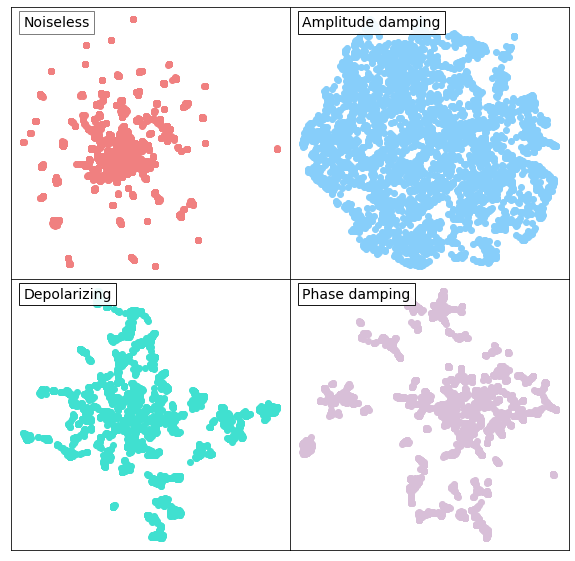

In [45]:
colors = ['lightskyblue', 'lightcoral', 'turquoise', 'thistle', 'lightgreen']
labels = ['Noiseless', 'Amplitude damping', 'Depolarizing', 'Phase damping']

fig, ax = plt.subplots(2,2,figsize=(10, 10))


ln1 = ax[0,0].scatter(embedding_NN_list[1,:,0], embedding_NN_list[1,:,1], color=colors[1])

t1 = ax[0,0].text(0,0.97, "Noiseless",fontsize=14)
t1.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='black'))

###########################################################################################

ax[0,1].scatter(embedding_AD_list[1,:,0], embedding_AD_list[1,:,1], cmap='Spectral', color=colors[0])
t2 = ax[0,1].text(0.0,0.97, "Amplitude damping",fontsize=14)
t2.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='black'))

ax[1,0].scatter(embedding_DP_list[1,:,0], embedding_DP_list[1,:,1], cmap='Spectral', color=colors[2])
t3 = ax[1,0].text(0,0.97, "Depolarizing",fontsize=14)
t3.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='black'))

ax[1,1].scatter(embedding_PD_list[1,:,0], embedding_PD_list[1,:,1], cmap='Spectral', color=colors[3])
t4 = ax[1,1].text(0,0.97, "Phase damping",fontsize=14)
t4.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='black'))

#lgnd = plt.legend([ln1, ln2, ln3, ln4], labels, bbox_to_anchor = (1,3))
#for handle in lgnd.legendHandles:
#    handle.set_sizes([30])
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.setp(ax, xticks=[], yticks=[])
plt.savefig('pauli_space_noise.png', format='png')
plt.show()

## 5. Example coefficients

In this example we show how the amplitude damping noise apart from mitigating the coefficients in the Pauli space, also introduces new non-zero coefficients. We create an example with the same toy model and visualize the coefficients of the distribution in the Pauli space for the three error models, together with the noiseless circuits.

In [94]:
paulis = pauli_basis(2)
paulis_mat = [p.to_matrix() for p in paulis]

# No errors
qc_tot = QuantumCircQiskit('G3', num_gates=10,nqbits=2,observables_type = 'all', err_type=None)
#  Create quanutm circuit only ONCE!
qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qc_tot.apply_G_gates(qc)
qubits = [i for i in range(qc.num_qubits)]
qc.append(SaveDensityMatrix(qc.num_qubits, label=f'rho'), qubits)


# No noise
backend = AerSimulator(method='density_matrix')
job = transpile(qc, backend)
result_noise = backend.run(qc, shots=1024).result()
density_matrix = np.array(result_noise.data()['rho'])
coefs_noiseless = [np.trace(density_matrix @ p).real for p in paulis_mat]


# Amplitude damping
qc_tot = QuantumCircQiskit('G3', num_gates=10,nqbits=2,observables_type = 'all', err_type='amplitude_damping',err_p1=0.2, err_p2=0.2)
backend = AerSimulator(method='density_matrix',noise_model=qc_tot.noise_model,basis_gates=qc_tot.basis_gates)
job = transpile(qc, backend)
result_noise = backend.run(qc, shots=1024).result()
density_matrix = np.array(result_noise.data()['rho'])
coefs_amplitude_damping = [np.trace(density_matrix @ p).real for p in paulis_mat]

# Depolarizing
qc_tot = QuantumCircQiskit('G3', num_gates=10,nqbits=2,observables_type = 'all', err_type='depolarizing',err_p1=0.2, err_p2=0.2)
backend = AerSimulator(method='density_matrix',noise_model=qc_tot.noise_model,basis_gates=qc_tot.basis_gates)
job = transpile(qc, backend)
result_noise = backend.run(qc, shots=1024).result()
density_matrix = np.array(result_noise.data()['rho'])
coefs_depolarizing = [np.trace(density_matrix @ p).real for p in paulis_mat]

# Phase damping
qc_tot = QuantumCircQiskit('G3', num_gates=10,nqbits=2,observables_type = 'all', err_type='phase_damping',err_p1=0.2, err_p2=0.2)
backend = AerSimulator(method='density_matrix',noise_model=qc_tot.noise_model,basis_gates=qc_tot.basis_gates)
job = transpile(qc, backend)
result_noise = backend.run(qc, shots=1024).result()
density_matrix = np.array(result_noise.data()['rho'])
coefs_phase_damping = [np.trace(density_matrix @ p).real for p in paulis_mat]


with open('coefs_noiseless.pickle', 'wb') as f:
    pickle.dump(coefs_noiseless,f)
    
with open('coefs_amplitude_damping.pickle', 'wb') as f:
    pickle.dump(coefs_amplitude_damping,f)
    
with open('coefs_depolarizing.pickle', 'wb') as f:
    pickle.dump(coefs_depolarizing,f)
    
with open('coefs_phase_damping.pickle', 'wb') as f:
    pickle.dump(coefs_phase_damping,f)

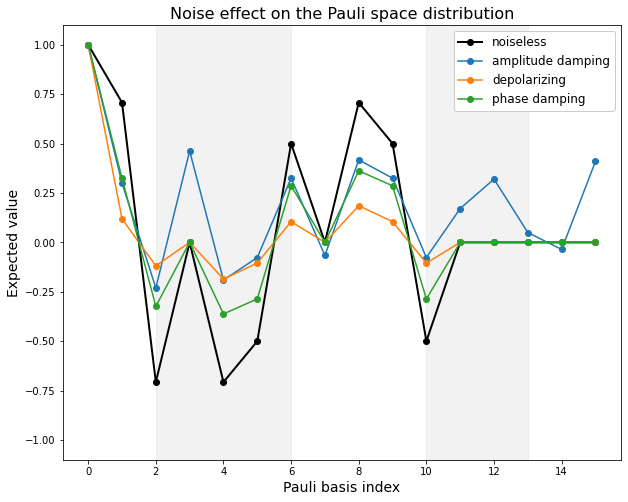

In [95]:
#idx+=2
fig = plt.figure(figsize=(10,8))
plt.plot(coefs_noiseless, linewidth=2, marker='o', color='black', label='noiseless')
plt.plot(coefs_amplitude_damping, marker='o', label='amplitude damping')
plt.plot(coefs_depolarizing, marker='o', label='depolarizing')
plt.plot(coefs_phase_damping, marker='o', label='phase damping')
plt.xlabel('Pauli basis index', fontsize=14)
plt.ylabel('Expected value', fontsize=14)
plt.title('Noise effect on the Pauli space distribution', fontsize=16)
plt.legend(fontsize=12, framealpha=1)
plt.fill_between([2,6],[-1.1,-1.1], [1.1,1.1], alpha=0.1, color='gray')
plt.fill_between([10,13],[-1.1,-1.1], [1.1,1.1], alpha=0.1, color='gray')
plt.ylim(-1.1,1.1)
#plt.savefig('noise_effect.png', format='png')
plt.show()